<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/multimodal_rag_with_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/multimodal_rag_with_milvus.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>

# Multimodal RAG with Milvus 🖼️

If you want to experience the final effect of this tutorial, you can go directly to [online demo](https://demos.milvus.io/multimodal-image-search/)

<img src="https://raw.githubusercontent.com/milvus-io/bootcamp/master/bootcamp/tutorials/quickstart/apps/multimodal_rag_with_milvus/pics/step3.jpg
"/>

This tutorial showcases the multimodal RAG powered by Milvus, [Visualized BGE model](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/visual), and [GPT-4o](https://openai.com/index/hello-gpt-4o/). With this system, users are able to upload an image and edit text instructions, which are processed by BGE's composed retrieval model to search for candidate images. GPT-4o then acts as a reranker, selecting the most suitable image and providing the rationale behind the choice. This powerful combination enables a seamless and intuitive image search experience, leveraging Milvus for efficient retrieval, BGE model for precise image processing and matching, and GPT-4o for advanced reranking.

## Preparation

### Install Dependencies

In [1]:
!pip install --upgrade pymilvus openai datasets opencv-python timm einops ftfy peft tqdm

In [2]:
!git clone https://github.com/FlagOpen/FlagEmbedding.git
!pip install -e FlagEmbedding

> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).

### Download Data

The following command will download the example data and extract to a local folder "./images_folder" including:

- **images**: A subset of [Amazon Reviews 2023](https://github.com/hyp1231/AmazonReviews2023) as containing approximately 900 images from the categories "Appliance", "Cell_Phones_and_Accessories", and "Electronics".
- **leopard.jpg**: An example query image.

In [3]:
!wget https://github.com/milvus-io/bootcamp/releases/download/data/amazon_reviews_2023_subset.tar.gz
!tar -xzf amazon_reviews_2023_subset.tar.gz

### Load Embedding Model

We will use the Visualized BGE model "bge-visualized-base-en-v1.5" to generate embeddings for both images and text. 

**1. Download weight**

In [4]:
!wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth

**2. Build encoder**

In [5]:
import torch
from FlagEmbedding.visual.modeling import Visualized_BGE


class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


model_name = "BAAI/bge-base-en-v1.5"
model_path = "./Visualized_base_en_v1.5.pth"  # Change to your own value if using a different model path
encoder = Encoder(model_name, model_path)

## Load Data

This section will load example images into the database with corresponding embeddings.

### Generate embeddings

Load all jpeg images from the data directory and apply the encoder to convert images to embeddings.

In [6]:
import os
from tqdm import tqdm
from glob import glob


# Generate embeddings for the image dataset
data_dir = (
    "./images_folder"  # Change to your own value if using a different data directory
)
image_list = glob(
    os.path.join(data_dir, "images", "*.jpg")
)  # We will only use images ending with ".jpg"
image_dict = {}
for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue
print("Number of encoded images:", len(image_dict))

Generating image embeddings: 100%|██████████| 900/900 [00:20<00:00, 44.08it/s]

Number of encoded images: 900


### Insert into Milvus

Insert images with corresponding paths and embeddings into Milvus collection.

> As for the argument of `MilvusClient`:
> - Setting the `uri` as a local file, e.g. `./milvus_demo.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
> - If you have large scale of data, you can set up a more performant Milvus server on [docker or kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your `uri`.
> - If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the `uri` and `token`, which correspond to the [Public Endpoint and Api key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#free-cluster-details) in Zilliz Cloud.

In [7]:
from pymilvus import MilvusClient


dim = len(list(image_dict.values())[0])
collection_name = "multimodal_rag_demo"

# Connect to Milvus client given URI
milvus_client = MilvusClient(uri="./milvus_demo.db")

# Create Milvus Collection
# By default, vector field name is "vector"
milvus_client.create_collection(
    collection_name=collection_name,
    auto_id=True,
    dimension=dim,
    enable_dynamic_field=True,
)

# Insert data into collection
milvus_client.insert(
    collection_name=collection_name,
    data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 7f33daeed99a4d8e8a5e28d47673ecc8
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created collection: multimodal_rag_demo
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: multimodal_rag_demo


{'insert_count': 900,
 'ids': [451537887696781312, 451537887696781313, ..., 451537887696782211],
 'cost': 0}

## Multimodal Search with Generative Reranker

In this section, we will firstly search for relevant images by a multimodal query and then use LLM service to rerank the results and find the best one with explanation.

### Run search

Now we are ready to perform the advanced image search with query data composed of both image and text instruction.

In [8]:
query_image = os.path.join(
    data_dir, "leopard.jpg"
)  # Change to your own query image path
query_text = "phone case with this image theme"

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
    collection_name=collection_name,
    data=[query_vec],
    output_fields=["image_path"],
    limit=9,  # Max number of search results to return
    search_params={"metric_type": "COSINE", "params": {}},  # Search parameters
)[0]

retrieved_images = [hit.get("entity").get("image_path") for hit in search_results]
print(retrieved_images)

['./images_folder/images/518Gj1WQ-RL._AC_.jpg', './images_folder/images/41n00AOfWhL._AC_.jpg', './images_folder/images/51Wqge9HySL._AC_.jpg', './images_folder/images/51R2SZiywnL._AC_.jpg', './images_folder/images/516PebbMAcL._AC_.jpg', './images_folder/images/51RrgfYKUfL._AC_.jpg', './images_folder/images/515DzQVKKwL._AC_.jpg', './images_folder/images/51BsgVw6RhL._AC_.jpg', './images_folder/images/51INtcXu9FL._AC_.jpg']


### Rerank with GPT-4o

We will use an LLM to rank images and generate an explanation for the best result based on the user query and retrieved results.

**1. Create a panoramic view**

In [9]:
import numpy as np
import cv2

img_height = 300
img_width = 300
row_count = 3


def create_panoramic_view(query_image_path: str, retrieved_images: list) -> np.ndarray:
    """
    creates a 5x5 panoramic view image from a list of images

    args:
        images: list of images to be combined

    returns:
        np.ndarray: the panoramic view image
    """
    panoramic_width = img_width * row_count
    panoramic_height = img_height * row_count
    panoramic_image = np.full(
        (panoramic_height, panoramic_width, 3), 255, dtype=np.uint8
    )

    # create and resize the query image with a blue border
    query_image_null = np.full((panoramic_height, img_width, 3), 255, dtype=np.uint8)
    query_image = Image.open(query_image_path).convert("RGB")
    query_array = np.array(query_image)[:, :, ::-1]
    resized_image = cv2.resize(query_array, (img_width, img_height))

    border_size = 10
    blue = (255, 0, 0)  # blue color in BGR
    bordered_query_image = cv2.copyMakeBorder(
        resized_image,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=blue,
    )

    query_image_null[img_height * 2 : img_height * 3, 0:img_width] = cv2.resize(
        bordered_query_image, (img_width, img_height)
    )

    # add text "query" below the query image
    text = "query"
    font_scale = 1
    font_thickness = 2
    text_org = (10, img_height * 3 + 30)
    cv2.putText(
        query_image_null,
        text,
        text_org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        blue,
        font_thickness,
        cv2.LINE_AA,
    )

    # combine the rest of the images into the panoramic view
    retrieved_imgs = [
        np.array(Image.open(img).convert("RGB"))[:, :, ::-1] for img in retrieved_images
    ]
    for i, image in enumerate(retrieved_imgs):
        image = cv2.resize(image, (img_width - 4, img_height - 4))
        row = i // row_count
        col = i % row_count
        start_row = row * img_height
        start_col = col * img_width

        border_size = 2
        bordered_image = cv2.copyMakeBorder(
            image,
            border_size,
            border_size,
            border_size,
            border_size,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        panoramic_image[
            start_row : start_row + img_height, start_col : start_col + img_width
        ] = bordered_image

        # add red index numbers to each image
        text = str(i)
        org = (start_col + 50, start_row + 30)
        (font_width, font_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2
        )

        top_left = (org[0] - 48, start_row + 2)
        bottom_right = (org[0] - 48 + font_width + 5, org[1] + baseline + 5)

        cv2.rectangle(
            panoramic_image, top_left, bottom_right, (255, 255, 255), cv2.FILLED
        )
        cv2.putText(
            panoramic_image,
            text,
            (start_col + 10, start_row + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    # combine the query image with the panoramic view
    panoramic_image = np.hstack([query_image_null, panoramic_image])
    return panoramic_image

Combine the query image and retrieved images with indices in a panoramic view.

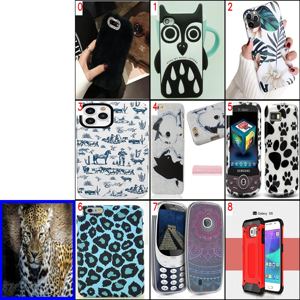

In [10]:
from PIL import Image

combined_image_path = os.path.join(data_dir, "combined_image.jpg")
panoramic_image = create_panoramic_view(query_image, retrieved_images)
cv2.imwrite(combined_image_path, panoramic_image)

combined_image = Image.open(combined_image_path)
show_combined_image = combined_image.resize((300, 300))
show_combined_image.show()

**2. Rerank and explain**

We will send the combined image to multimodal LLM service together with proper prompts to rank the retrieved results with explanation. To enable GPT-4o as the LLM, you need to prepare your [OpenAI API Key](https://platform.openai.com/docs/quickstart).

In [11]:
import requests
import base64


openai_api_key = "sk-***"  # Change to your OpenAI API Key


def generate_ranking_explanation(
    combined_image_path: str, caption: str, infos: dict = None
) -> tuple[list[int], str]:
    with open(combined_image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    information = (
        "You are responsible for ranking results for a Composed Image Retrieval. "
        "The user retrieves an image with an 'instruction' indicating their retrieval intent. "
        "For example, if the user queries a red car with the instruction 'change this car to blue,' a similar type of car in blue would be ranked higher in the results. "
        "Now you would receive instruction and query image with blue border. Every item has its red index number in its top left. Do not misunderstand it. "
        f"User instruction: {caption} \n\n"
    )

    # add additional information for each image
    if infos:
        for i, info in enumerate(infos["product"]):
            information += f"{i}. {info}\n"

    information += (
        "Provide a new ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1 most suitable item only. "
        "The format of the response has to be 'Ranked list: []' with the indices in brackets as integers, followed by 'Reasons:' plus the explanation why this most fit user's query intent."
    )

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}",
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": information},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        "max_tokens": 300,
    }

    response = requests.post(
        "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
    )
    result = response.json()["choices"][0]["message"]["content"]

    # parse the ranked indices from the response
    start_idx = result.find("[")
    end_idx = result.find("]")
    ranked_indices_str = result[start_idx + 1 : end_idx].split(",")
    ranked_indices = [int(index.strip()) for index in ranked_indices_str]

    # extract explanation
    explanation = result[end_idx + 1 :].strip()

    return ranked_indices, explanation

Get the image indices after ranking and the reason for the best result:

In [12]:
ranked_indices, explanation = generate_ranking_explanation(
    combined_image_path, query_text
)

**3. Display the best result with explanation**

Reasons: The most suitable item for the user's query intent is index 6 because the instruction specifies a phone case with the theme of the image, which is a leopard. The phone case with index 6 has a thematic design resembling the leopard pattern, making it the closest match to the user's request for a phone case with the image theme.


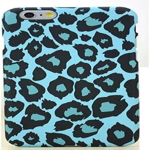

In [13]:
print(explanation)

best_index = ranked_indices[0]
best_img = Image.open(retrieved_images[best_index])
best_img = best_img.resize((150, 150))
best_img.show()

### Quick Deploy

To learn about how to start an online demo with this tutorial, please refer to [the example application](https://github.com/milvus-io/bootcamp/tree/master/bootcamp/tutorials/quickstart/apps/multimodal_rag_with_milvus).